# 2025 CITS4012 Project

_Make sure you change the file name with your group id._


In [40]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.metrics import accuracy_score, f1_score, classification_report  # ADD THIS LINE
from sklearn.utils.class_weight import compute_class_weight


import nltk
if not nltk.download('punkt'):
    nltk.download('punkt')
    nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

if not nltk.download('stopwords'):
    nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.utils.class_weight import compute_class_weight


# Stemmer and Lemmatizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

if not nltk.download('wordnet'):
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    nltk.download('averaged_perceptron_tagger')

sys.path.append(os.path.abspath('..')) 
import math


import torch
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

sys.path.append(os.path.abspath('../')) # Points to the current folder 

CUDA available: False
CUDA version: None
Number of GPUs: 0


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\msi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\msi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\msi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import time
import math

# Helper functions for training
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### **We build a Configuration class to have all the hyperparameters together**


In [4]:

# Class construct for hyperparameters 
class Config:
    def __init__(self):
        self.min_word_len = 3
        self.max_word_len = 64
        self.train_num_epoch = 1
        self.batch_size = 64
        
        self.embedding_dim = 200
        self.hidden_dim = 64
        self.max_combined_len = 130 #to join premise + hypothesis + cls + sep 
        self.patience = 5
        #Embedding
        self.embedding_method = ""
        self.emb_lr = 0.0005
        self.emb_epoch = 3
        self.emb_window_size = 5
        # Models
        self.n_heads = 2
        self.n_layers = 1
        self.dropout = 0.3
        self.num_classes = 2
        self.lr = 0.00005
        self.wd = 0.0005
        self.train_num_epoch = 7
        self.label_smoothing = 0.0

    def display(self): # Display all the config parameters 
        print("=" * 60)
        print("CONFIGURATION PARAMETERS")
        print("=" * 60)
        print("\nEmbedding Parameters:")
        print(f"  Method: {self.embedding_method}")
        print(f"  Max length: {self.max_word_len}")
        print(f"  Learning rate: {self.emb_lr}")
        print(f"  Embedding size: {self.embedding_dim}")
        print(f"  Epochs: {self.emb_epoch}")
        print(f"  Window size: {self.emb_window_size}")
        
        print("\nTransformer Parameters:")
        print(f"  Batch size: {self.batch_size}")
        print(f"  Number of heads: {self.n_heads}")
        print(f"  Number of layers: {self.n_layers}")
        print(f"  Dropout: {self.dropout}")
        print(f"  Number of classes: {self.num_classes}")
        print(f"  Learning rate: {self.lr}")
        print(f"  Weight decay: {self.wd}")
        print(f"  Training epochs: {self.train_num_epoch}")

        print(f"  Label smoothing: {self.label_smoothing}")
        print("=" * 60)


In [5]:
hyperparameters = Config()

# Readme


# 1.Dataset Processing


In [6]:

# These are common English contractions.
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}


# Helper function for lemmatization with POS tagging
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if no match
    
# Allowed POS tags for filtering (example: nouns, verbs, adjectives, adverbs)
allowed_pos_tags = {'NN', 'NNS', 'NNP', 'NNPS',   # Nouns
                    'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',  # Verbs
                    'JJ', 'JJR', 'JJS',           # Adjectives
                    'RB', 'RBR', 'RBS'}           # Adverbs

# Filter the desired POS tags
def filter_tokens_by_pos(tokens):
    tagged_tokens = pos_tag(tokens)
    filtered = [word for word, tag in tagged_tokens if tag in allowed_pos_tags]
    return filtered

def clean_dataset(dataset, min_word_len, max_word_len, method=['stem, lemmatize'], pos_filter=False, stop_w=False, clean_nums = False):
    cleaned_premises = []
    cleaned_hypotheses = []
    cleaned_labels = []

    for index, row in dataset.iterrows():
        premise = row['premise']
        hypothesis = row['hypothesis']
        label = row['label']

        # Lowercase
        premise = premise.lower()
        hypothesis = hypothesis.lower()

        # Expand contractions
        for contraction, full_form in contraction_dict.items():
            premise = premise.replace(contraction, full_form)
            hypothesis = hypothesis.replace(contraction, full_form)

        # Remove punctuation/special chars
        premise = re.sub(r'[^a-zA-Z0-9\s.-]', ' ', premise)
        hypothesis = re.sub(r'[^a-zA-Z0-9\s.-]', ' ', hypothesis)

        # Replace underscores/hyphens with spaces, then normalize whitespace
        premise = re.sub(r'[-–—_]+', ' ', premise)
        hypothesis = re.sub(r'[-–—_]+', ' ', hypothesis)

        # Normalize whitespace
        premise = re.sub(r'\s+', ' ', premise).strip()
        hypothesis = re.sub(r'\s+', ' ', hypothesis).strip()

        # Tokenization
        premise_tokens = word_tokenize(premise)
        hypothesis_tokens = word_tokenize(hypothesis)

        # # Replace numbers with '<NUM>'
        if clean_nums is True:
            premise_tokens = ['[NUM]' if any(char.isdigit() for char in word) else word for word in premise_tokens]
            hypothesis_tokens = ['[NUM]' if any(char.isdigit() for char in word) else word for word in hypothesis_tokens]


        # Stemming/Lemmatization
        if 'stem' in method:
            stemmer = PorterStemmer()
            premise_tokens = [stemmer.stem(word) for word in premise_tokens]
            hypothesis_tokens = [stemmer.stem(word) for word in hypothesis_tokens]
        elif 'lemmatize' in method:
            lemmatizer = WordNetLemmatizer()
            premise_pos_tags = pos_tag(premise_tokens)
            hypothesis_pos_tags = pos_tag(hypothesis_tokens)
            premise_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in premise_pos_tags]
            hypothesis_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in hypothesis_pos_tags]

        # POS Filtering
        if pos_filter:
            premise_tokens = filter_tokens_by_pos(premise_tokens)
            hypothesis_tokens = filter_tokens_by_pos(hypothesis_tokens)

        # Remove stop words
        if stop_w:
            premise_tokens = [word for word in premise_tokens if word not in stop_words]
            hypothesis_tokens = [word for word in hypothesis_tokens if word not in stop_words]

        # Now check token length AFTER cleaning
        if (min_word_len <= len(premise_tokens) <= max_word_len and
            min_word_len <= len(hypothesis_tokens) <= max_word_len):
            cleaned_premises.append(premise_tokens)
            cleaned_hypotheses.append(hypothesis_tokens)
            cleaned_labels.append(label)
        # else: skip row

    # Build DataFrame from all cleaned token lists
    new_dataset = pd.DataFrame({
        'premise': cleaned_premises,
        'hypothesis': cleaned_hypotheses,
        'label': cleaned_labels
    })

    return new_dataset

## 1.1 Make the Datasets


In [7]:
# Load raw data
train_df = pd.read_json('train.json')
test_df = pd.read_json('test.json')
validation_df = pd.read_json('validation.json')

# Clean datasets. MAX_WORD_LENGTH set to 64 to remove very long texts
clean_train_dataset = clean_dataset(train_df, hyperparameters.min_word_len, hyperparameters.max_word_len, stop_w=True, method=[], pos_filter=False)
clean_test_dataset = clean_dataset(test_df, hyperparameters.min_word_len, hyperparameters.max_word_len,stop_w=True, method=[], pos_filter= False )
clean_validation_dataset = clean_dataset(validation_df, hyperparameters.min_word_len, hyperparameters.max_word_len,stop_w=True, method=[], pos_filter= False )

# Combine clean premises and hypotheses
clean_t_dataset = clean_train_dataset['premise'] + clean_train_dataset['hypothesis']
clean_t_dataset.head()

0    [pluto, rotates, axis, every, 6.39, earth, day...
1    [glenn, per, day, earth, rotates, axis, ., ear...
2    [geysers, periodic, gush, hot, water, surface,...
3    [facts, liquid, water, droplets, changed, invi...
4    [comparison, earth, rotates, axis, per, day, r...
dtype: object

In [8]:
sum(train_df['label']=='entails') / (sum(train_df['label']!='entails') + sum(train_df['label']=='entails'))

0.36685724185724183

In [9]:
sum(validation_df['label']=='entails') / (sum(validation_df['label']!='entails') + sum(validation_df['label']=='entails'))

0.5038343558282209

In [10]:
sum(test_df['label']=='entails') / (sum(test_df['label']!='entails') + sum(test_df['label']=='entails'))

0.39604891815616183

In [11]:
# Create a unique word list from the cleaned dataset
unique_words = set()
for sentence in clean_t_dataset: # Both Premise and Hypothesis 
    for word in sentence:
        unique_words.add(word)
        
unique_words_list = sorted(list(unique_words))

# Make dictionary of words and indices
word2id = {w:i for i,w in enumerate(unique_words_list)}
id2word = {i:w for i,w in enumerate(unique_words_list)}


# Add special tokens to use later
SPECIAL_TOKENS = ['[PAD]','[UNK]','[CLS]','[SEP]'] 
for tok in SPECIAL_TOKENS:
    if tok not in word2id:
        idx = len(word2id)
        word2id[tok] = idx
        id2word[idx] = tok


In [12]:
SEP_ID = word2id['[SEP]']
UNK_ID = word2id['[UNK]']
PAD_ID = word2id['[PAD]']
CLS_ID = word2id['[CLS]']


def prepare_indexed_data(df, word2id, max_len):
    input_ids = []
    attention_mask = []
    labels = []

    label_map = {'neutral': 0, 'entails': 1}

    for _, row in df.iterrows():
        premise_toks = row['premise']
        hypothesis_toks = row['hypothesis']
        label = row['label']

        # Add special tokens 
        tokens = [CLS_ID] \
                + [word2id.get(w,UNK_ID) for w in premise_toks] \
                + [SEP_ID] \
                + [word2id.get(w,UNK_ID) for w in hypothesis_toks] 
        # Truncate
        tokens = tokens[:max_len] #to combine len of hypothesis and premise, plus cls and sep  

        # Attention mask 
        attn = [1] * len(tokens)

        # Pad
        pad_len = max_len - len(tokens) # To fill the [PAD]
        if pad_len > 0:
            tokens += [PAD_ID] * pad_len
            attn += [0] * pad_len # FLag positions as padding 

        input_ids.append(tokens)
        attention_mask.append(attn)
        labels.append(label_map[label])

    return (torch.LongTensor(input_ids),
            np.array(input_ids),
            torch.LongTensor(attention_mask),
            torch.LongTensor(labels))

Shape of x_train: torch.Size([22900, 130])
Shape of train_masks: torch.Size([22900, 130])
Shape of y_train: torch.Size([22900])

--- Example ---
First example real length (mask sum): 16
First example PAD count: 114


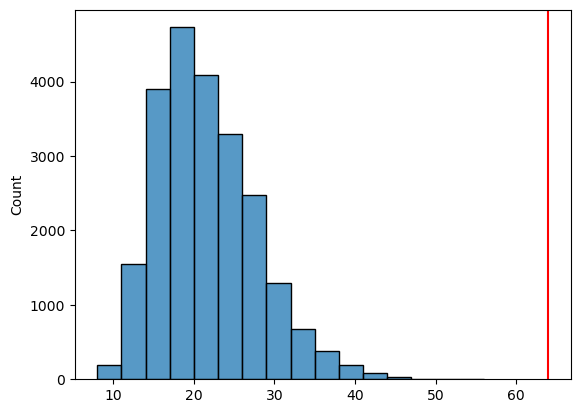

In [13]:
# Build train/test
x_train, plain_train, train_masks, y_train = prepare_indexed_data(clean_train_dataset, word2id, hyperparameters.max_combined_len)
x_test,  plain_test, test_masks,  y_test  = prepare_indexed_data(clean_test_dataset,  word2id, hyperparameters.max_combined_len)
x_valid,  plain_valid, valid_masks,  y_valid  = prepare_indexed_data(clean_validation_dataset,  word2id, hyperparameters.max_combined_len)

print("Shape of x_train:", x_train.shape)
print("Shape of train_masks:", train_masks.shape)
print("Shape of y_train:", y_train.shape)

# Sanity Check 
i = 0
print("\n--- Example ---")
print("First example real length (mask sum):", int(train_masks[i].sum()))
print("First example PAD count:", int((train_masks[i]==0).sum()))

# Check we didn't cut off too much
sns.histplot(np.sum(train_masks.numpy(), axis=1), bins = 16)
plt.axvline(hyperparameters.max_word_len, color='red')
plt.show()

# Prepare the datasets for model training
train_ds = TensorDataset(x_train, train_masks, y_train)
test_ds = TensorDataset(x_test, test_masks,y_test)
valid_ds = TensorDataset(x_valid, valid_masks,y_valid)

# Dataloaders (shuffle for train)
train_loader = DataLoader(train_ds, batch_size=hyperparameters.batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=hyperparameters.batch_size, shuffle=False, num_workers=0)
valid_loader = DataLoader(valid_ds, batch_size=hyperparameters.batch_size, shuffle=False, num_workers=0)

In [14]:
# Get the first batch from the train_loader Get the first batch from the train_loader

## 1.1 Make an embedding model


In [15]:
from gensim.models import FastText

fast_text_model = FastText(clean_t_dataset, # Both premise and Hypothesis 
                           vector_size=hyperparameters.embedding_dim,
                           window=hyperparameters.emb_window_size,
                           sg=1,
                           epochs=hyperparameters.emb_epoch
                           )

fast_text_model.wv.most_similar('saturn', topn=10)

def build_embedding_matrix(word2id, pretrained_vectors, embedding_size):
    vocab_size = len(word2id)
    embedding_matrix = np.zeros((vocab_size, embedding_size), dtype=np.float32)

    # Fill the matrix with the pre-trained vectors
    for word, idx in word2id.items():
        if word == '[PAD]':# If [PAD] ignore 
            continue
        try:
            vec = pretrained_vectors[word] #Checks the size of the vector of each word
            if vec.shape[0] == embedding_size:
                embedding_matrix[idx] = vec.astype(np.float32)
            else:
                # fallback if dims don’t match
                embedding_matrix[idx] = np.random.normal(0.0, 0.02, size=(embedding_size,)).astype(np.float32)
        except KeyError:
            # special tokens or OOV start them with random values 
            embedding_matrix[idx] = np.random.normal(0.0, 0.02, size=(embedding_size,)).astype(np.float32)

    print("Embedding matrix created with shape:", embedding_matrix.shape)

    return embedding_matrix


embedding_matrix = build_embedding_matrix(word2id, fast_text_model.wv, hyperparameters.embedding_dim)

Embedding matrix created with shape: (20264, 200)


In [16]:
#check if it works
# print(f"✅ Embedding matrix type: {type(embedding_matrix)}")
# print(f"✅ Embedding matrix device: {embedding_matrix.device if hasattr(embedding_matrix, 'device') else 'numpy array'}")

✅ Embedding matrix type: <class 'numpy.ndarray'>
✅ Embedding matrix device: numpy array


In [17]:
# CHUNK 4: EMBEDDINGS & POSITIONAL ENCODING
print("🔤 Creating embeddings...")
def create_embedding_matrix(word2id, embedding_dim):
    """Create embedding matrix"""
    vocab_size = len(word2id)
    embedding_matrix = np.random.normal(0, 0.1, (vocab_size, embedding_dim))
    # Set padding to zeros
    embedding_matrix[PAD_ID] = np.zeros(embedding_dim)
    # CONVERT TO PYTORCH TENSOR - THIS IS THE FIX
    return torch.FloatTensor(embedding_matrix)  # Already correct!

embedding_matrix = create_embedding_matrix(word2id, hyperparameters.embedding_dim)
print(f"🔤 Embedding matrix: {embedding_matrix.shape}")
print(f"🔤 Embedding matrix type: {type(embedding_matrix)}")  # Should be torch.Tensor

🔤 Creating embeddings...
🔤 Embedding matrix: torch.Size([20264, 200])
🔤 Embedding matrix type: <class 'torch.Tensor'>


In [18]:
vocab_size = len(word2id)

In [19]:
# Look at embedding matrix with random words
candidates = [i for i in range(embedding_matrix.shape[0]) 
              if id2word.get(i) not in (None, "[PAD]")]

rng = np.random
chosen = rng.choice(candidates, size=min(5, len(candidates)), replace=False)

print(f"{'idx':>4}  {'token':<20}  first 5 dims")
print("-" * 80)
for i in chosen:
    token = id2word[i]
    print(f"{i:>4}  {token:<20}  {embedding_matrix[i][:5]}")

 idx  token                 first 5 dims
--------------------------------------------------------------------------------
1619  antarctic             tensor([ 0.0413, -0.0466,  0.0563, -0.1083,  0.0254])
12472  needlessly            tensor([-0.1340, -0.0400, -0.0625, -0.0684,  0.0397])
15578  repetitive            tensor([-0.0374, -0.1523,  0.0493,  0.0365, -0.0651])
12397  naplate               tensor([-0.0828, -0.0441,  0.0254,  0.1505,  0.0847])
13917  phototroph            tensor([0.0149, 0.1098, 0.1413, 0.0998, 0.0361])


# 2. Model Implementation


Note we have collected following parameters from the pre-processing:

- VOCAB_SIZE
- MAX_SEQ_LEN
- BATCH_SIZE
- embedding_dim
  We have collected the objects:
- embedding_matrix
- fast_text_model
- clean_train_dataset, clean_test_dataset, clean_validation_dataset


**We build a Configuration class to have all the hyperparameters together**


## Positional Encoding


In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len = 512, dropout = 0.1):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0,max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0) / d_model))
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        x = x + self.pe[:, :x.size(1), :] 
        return self.dropout(x)

## Define Different Attention

### Additive Attention

In [21]:
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attention_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, sequence_output):
        scores = self.attention_net(sequence_output)
        weights = torch.softmax(scores, dim=1)
        context = torch.sum(weights * sequence_output, dim=1)
        return context, weights

### Cross Attention

In [22]:
def apply_cross_attention(source_seq, target_seq):
    scores = torch.bmm(source_seq, target_seq.transpose(1, 2))
    scores = scores / math.sqrt(source_seq.size(-1))
    weights = torch.softmax(scores, dim=-1)
    context = torch.bmm(weights, target_seq)
    return context, weights

### MultiHead Self Attention

In [23]:
class MultiHeadSelfAttention(nn.Module):
    """Transformer-style multi-head self-attention"""
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.mha = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=0.1,
            batch_first=True
        )
    
    def forward(self, sequence, padding_mask=None):
        output, weights = self.mha(
            sequence, sequence, sequence,
            key_padding_mask=padding_mask
        )
        return output, weights

## Model A: RNN with Attention


### LSTM With Attention


In [24]:
class LSTMAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=2, dropout=0.3, num_layers = 2):
        super(LSTMAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers, dropout=dropout)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, x, mask=None, return_weights = False):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        context = self.dropout(context)

        logits = self.fc(context)
        if return_weights:
            return logits, attn_weights
        else:
            return logits

### Gru with Additive Attention


In [25]:
class GRUAdditiveAttention(nn.Module):
    """GRU with additive attention"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_ID)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = AdditiveAttention(hidden_dim * 2)
        self.classifier = nn.Linear(hidden_dim * 2, 2)
    
    def forward(self, x, mask=None):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        context, _ = self.attention(gru_out)
        logits = self.classifier(context)
        return logits


In [26]:
class GRUCrossAttention(nn.Module):
    """GRU with cross attention between premise and hypothesis"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_ID)
        self.premise_gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.hypothesis_gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_dim * 4, 2)
    
    def forward(self, x, mask=None):
        # Split input
        sep_pos = (x == SEP_ID).int().argmax(dim=1)
        premise_mask = torch.arange(x.size(1), device=x.device).unsqueeze(0) < sep_pos.unsqueeze(1)
        hypothesis_mask = ~premise_mask & (x != PAD_ID)
        
        premise = torch.where(premise_mask, x, PAD_ID)
        hypothesis = torch.where(hypothesis_mask, x, PAD_ID)
        
        # Encode separately
        prem_emb = self.embedding(premise)
        hypo_emb = self.embedding(hypothesis)
        
        prem_encoded, _ = self.premise_gru(prem_emb)
        hypo_encoded, _ = self.hypothesis_gru(hypo_emb)
        
        # Cross attention
        cross_context, _ = apply_cross_attention(hypo_encoded, prem_encoded)
        
        # Pool and combine
        hypo_pooled = hypo_encoded.mean(dim=1)
        cross_pooled = cross_context.mean(dim=1)
        combined = torch.cat([hypo_pooled, cross_pooled], dim=1)
        
        logits = self.classifier(combined)
        return logits


In [27]:

class GRUMultiHeadAttention(nn.Module):
    """GRU with multi-head self-attention"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_heads=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_ID)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.multihead_attn = MultiHeadSelfAttention(hidden_dim * 2, num_heads)
        self.classifier = nn.Linear(hidden_dim * 2, 2)
    
    def forward(self, x, mask=None):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        attn_out, _ = self.multihead_attn(gru_out, padding_mask=(x == PAD_ID))
        context = attn_out.mean(dim=1)
        logits = self.classifier(context)
        return logits

## Model B: Transformer with Attention


In [28]:
class TransformerClassifier(nn.Module):
    def __init__(self, embedding_matrix, num_classes, n_heads, n_layers, dropout):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.d_model = embed_dim

        # Embedding Layer
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False, padding_idx=word2id['[PAD]'])

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=hyperparameters.max_combined_len, dropout=hyperparameters.dropout)

        # Transformer Encoder Layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=n_heads,
            dropout=hyperparameters.dropout,
            dim_feedforward=(embed_dim*4),
            batch_first=True 
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer,num_layers=n_layers)

        # Final Classification Head
        #self.classifier = nn.Linear(embed_dim,num_classes)

        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_classes)
        )

    def forward(self, src, src_mask):
        padding_mask = (src_mask == 0)

        # Apply embedding and positional encoding
        embedded = self.embedding(src) * math.sqrt(self.d_model)
        pos_encoded = self.pos_encoder(embedded)

        # Pass trough the transformer encoder
        encoded = self.transformer_encoder(pos_encoded,src_key_padding_mask = padding_mask)

        # Use the output of the [CLS] token for classification
        cls_output = encoded[:,0,:]

        # Get final logits from the classifier
        logits = self.classifier(cls_output)
        return logits
    
    # Get attention from the first layer
    def get_attention_weights(self, src, src_mask):
        # Get embeddings and positional encoding
        padding_mask = (src_mask == 0)
        embedded = self.embedding(src) * math.sqrt(self.d_model)
        pos_encoded = self.pos_encoder(embedded)

        # Access the FIRST encoder layer 
        first_encoder_layer = self.transformer_encoder.layers[0]

        # Call its self-attention module with need_weights=True
        _, attn_weights = first_encoder_layer.self_attn(
            pos_encoded, pos_encoded, pos_encoded,
            key_padding_mask=padding_mask,
            need_weights=True,
            average_attn_weights=False
        )

        return attn_weights.cpu().detach()

In [29]:
class TransformerAdditiveAttention(nn.Module):
    """Transformer with additive attention over all tokens"""
    def __init__(self, embedding_matrix, n_heads, n_layers):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.d_model = embed_dim
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=PAD_ID)
        self.pos_encoder = PositionalEncoding(embed_dim, hyperparameters.max_combined_len)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, n_layers)
        
        self.additive_attn = AdditiveAttention(embed_dim)
        self.classifier = nn.Linear(embed_dim, 2)
    
    def forward(self, x, mask=None):
        padding_mask = (x == PAD_ID)
        embedded = self.embedding(x) * math.sqrt(self.d_model)
        pos_encoded = self.pos_encoder(embedded)
        encoded = self.transformer(pos_encoded, src_key_padding_mask=padding_mask)
        context, _ = self.additive_attn(encoded)
        logits = self.classifier(context)
        return logits


In [30]:
class TransformerCrossAttention(nn.Module):
    """Transformer with cross attention between streams"""
    def __init__(self, embedding_matrix, n_heads, n_layers):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.d_model = embed_dim
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=PAD_ID)
        self.pos_encoder = PositionalEncoding(embed_dim, hyperparameters.max_combined_len)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dropout=0.1, batch_first=True
        )
        self.premise_transformer = nn.TransformerEncoder(encoder_layer, n_layers)
        self.hypothesis_transformer = nn.TransformerEncoder(encoder_layer, n_layers)
        
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=embed_dim, num_heads=n_heads, batch_first=True
        )
        self.classifier = nn.Linear(embed_dim * 2, 2)
    
    def forward(self, x, mask=None):
        # Split input
        sep_pos = (x == SEP_ID).int().argmax(dim=1)
        premise_mask = torch.arange(x.size(1), device=x.device).unsqueeze(0) < sep_pos.unsqueeze(1)
        hypothesis_mask = ~premise_mask & (x != PAD_ID)
        
        premise = torch.where(premise_mask, x, PAD_ID)
        hypothesis = torch.where(hypothesis_mask, x, PAD_ID)
        
        # Encode separately
        prem_emb = self.embedding(premise) * math.sqrt(self.d_model)
        hypo_emb = self.embedding(hypothesis) * math.sqrt(self.d_model)
        
        prem_encoded = self.premise_transformer(
            self.pos_encoder(prem_emb), 
            src_key_padding_mask=(premise == PAD_ID)
        )
        hypo_encoded = self.hypothesis_transformer(
            self.pos_encoder(hypo_emb),
            src_key_padding_mask=(hypothesis == PAD_ID)
        )
        
        # Cross attention
        cross_out, _ = self.cross_attn(
            hypo_encoded, prem_encoded, prem_encoded,
            key_padding_mask=(premise == PAD_ID)
        )
        
        # Use [CLS] tokens
        prem_cls = prem_encoded[:, 0, :]
        cross_cls = cross_out[:, 0, :]
        combined = torch.cat([prem_cls, cross_cls], dim=1)
        
        logits = self.classifier(combined)
        return logits

In [31]:
class TransformerMultiHead(nn.Module):
    """Standard transformer with multi-head self-attention"""
    def __init__(self, embedding_matrix, n_heads, n_layers):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.d_model = embed_dim
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=PAD_ID)
        self.pos_encoder = PositionalEncoding(embed_dim, hyperparameters.max_combined_len)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, n_layers)
        self.classifier = nn.Linear(embed_dim, 2)
    
    def forward(self, x, mask=None):
        padding_mask = (x == PAD_ID)
        embedded = self.embedding(x) * math.sqrt(self.d_model)
        pos_encoded = self.pos_encoder(embedded)
        encoded = self.transformer(pos_encoded, src_key_padding_mask=padding_mask)
        cls_output = encoded[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

## Model C: Wide and Deep RNN


This model seeks to build on Model A by splitting into three components


In [32]:
class GRUThreeStreamNLI(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, wide_layers=2, prem_layers=2, hypo_layers=2, num_fc_layers=2, embedding_dropout=0.2, dropout=0.3, unk_prob=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embed_dropout = nn.Dropout(embedding_dropout)
        self.dropout = nn.Dropout(dropout)

        # Encoders
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True,
                          bidirectional=True, num_layers=wide_layers, dropout=dropout if wide_layers > 1 else 0.0)
        self.prem_encoder = nn.GRU(
            embedding_dim, hidden_dim, num_layers=prem_layers,
            batch_first=True, bidirectional=True, dropout=dropout if prem_layers > 1 else 0.0
        )
        self.hypo_encoder = nn.GRU(
            embedding_dim, hidden_dim, num_layers=hypo_layers,
            batch_first=True, bidirectional=True, dropout=dropout if hypo_layers > 1 else 0.0
        )

        self.norm = nn.LayerNorm(hidden_dim * 2)


        # Self-attention for premise and hypothesis
        self.self_attn = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        # Cross-attention for the wide stream
        self.cross_attn_query = nn.Linear(hidden_dim * 2, hidden_dim)
        self.cross_attn_key = nn.Linear(hidden_dim * 2, hidden_dim)
        self.cross_attn_value = nn.Linear(hidden_dim * 2, hidden_dim)

        # Fusion and classification layers
        fusion_dim = hidden_dim * (4 + 2 + 2)  # 4H from cross + 2H + 2H = 8H total
        fc_layers = []
        in_dim = fusion_dim
        out_dim = hidden_dim * 2

        for i in range(num_fc_layers):
            fc_layers.extend([
                nn.Linear(in_dim, out_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            # for next layer
            in_dim = out_dim
            # Optionally shrink layer width gradually:
            out_dim = max(hidden_dim, out_dim // 2)

        self.fc_layers = nn.Sequential(*fc_layers)
        self.classifier = nn.Linear(in_dim, 2)
        self.unk_id = UNK_ID
        self.unk_prob = unk_prob


    def forward(self, x, mask=None):
        # Token corruption (word dropout)
        if self.training and self.unk_prob > 0:
            mask = (x != PAD_ID) & (x != SEP_ID) & (x != CLS_ID) & (x != UNK_ID)
            replace_mask = (torch.rand_like(x.float()) < self.unk_prob) & mask
            x = torch.where(replace_mask, torch.full_like(x, self.unk_id), x)

        # Split into premise/hypothesis 
        sep_positions = (x == SEP_ID).int().argmax(dim=1)
        batch_idx = torch.arange(x.size(0), device=x.device)
        token_range = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        premise_mask = token_range < sep_positions.unsqueeze(1)
        hypothesis_mask = token_range > sep_positions.unsqueeze(1)
        premise = torch.where(premise_mask, x, PAD_ID)
        hypothesis = torch.where(hypothesis_mask, x, PAD_ID)

        #  Embeddings
        embedded = self.embed_dropout(self.embedding(x).transpose(1,2)).transpose(1,2)
        emb_prem = self.embed_dropout(self.embedding(premise).transpose(1,2)).transpose(1,2)
        emb_hypo = self.embed_dropout(self.embedding(hypothesis).transpose(1,2)).transpose(1,2)

        # Encode all three streams
        full_out, _ = self.gru(embedded)
        prem_out, _ = self.gru(emb_prem)
        hypo_out, _ = self.gru(emb_hypo)

        full_out = self.norm(full_out)
        prem_out, _ = self.prem_encoder(emb_prem)
        hypo_out, _ = self.hypo_encoder(emb_hypo)

        # # Wide stream (cross-attention over full sequence)
        # Q = self.cross_attn_query(full_out)
        # K = self.cross_attn_key(full_out)
        # V = self.cross_attn_value(full_out)
        # attn_scores = torch.bmm(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        # attn_weights = F.softmax(attn_scores, dim=-1)
        # cross_context = torch.bmm(attn_weights, V).mean(dim=1)  # (B, hidden_dim)

        # --- Bidirectional cross-attention between premise and hypothesis ---
        # Project to query/key/value spaces
        Q_p = self.cross_attn_query(prem_out)   # (B, Lp, H)
        K_h = self.cross_attn_key(hypo_out)
        V_h = self.cross_attn_value(hypo_out)

        Q_h = self.cross_attn_query(hypo_out)   # (B, Lh, H)
        K_p = self.cross_attn_key(prem_out)
        V_p = self.cross_attn_value(prem_out)

        # Premise → Hypothesis attention (H attends to P)
        scores_h2p = torch.bmm(Q_h, K_p.transpose(1, 2)) / (Q_h.size(-1) ** 0.5)
        weights_h2p = F.softmax(scores_h2p, dim=-1)
        context_h2p = torch.bmm(weights_h2p, V_p)  # (B, Lh, H)

        # Hypothesis → Premise attention (P attends to H)
        scores_p2h = torch.bmm(Q_p, K_h.transpose(1, 2)) / (Q_p.size(-1) ** 0.5)
        weights_p2h = F.softmax(scores_p2h, dim=-1)
        context_p2h = torch.bmm(weights_p2h, V_h)  # (B, Lp, H)

        # Pool both directions
        context_h2p = context_h2p.mean(dim=1)  # (B, H)
        context_p2h = context_p2h.mean(dim=1)  # (B, H)

        # Fuse bidirectional cross contexts
        cross_context = torch.cat([
            context_p2h,                   # P→H
            context_h2p,                   # H→P
            torch.abs(context_p2h - context_h2p),  # difference
            context_p2h * context_h2p              # element-wise product
        ], dim=1)  # (B, 4H)

        # Deep streams (self-attention pooling)
        def self_attention_pooling(out):
            weights = F.softmax(self.self_attn(out), dim=1)  # (B, L, 1)
            return torch.sum(weights * out, dim=1)           # (B, 2H)

        prem_context = self_attention_pooling(prem_out)
        hypo_context = self_attention_pooling(hypo_out)

        # Fusion
        fused = torch.cat([cross_context, prem_context, hypo_context], dim=1)
        fused = self.fc_layers(fused)
        logits = self.classifier(fused)

        return logits

In [33]:
contain_UNK = np.zeros(len(plain_valid), dtype=bool)
for i, sent in enumerate(plain_valid):
    if UNK_ID in sent:
        contain_UNK[i] = True

In [34]:
class TransformerAdditiveAttention(nn.Module):
    """Transformer with additive attention over all tokens"""
    def __init__(self, embedding_matrix, n_heads, n_layers):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.d_model = embed_dim
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=PAD_ID)
        self.pos_encoder = PositionalEncoding(embed_dim, hyperparameters.max_combined_len)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, n_layers)
        
        self.additive_attn = AdditiveAttention(embed_dim)
        self.classifier = nn.Linear(embed_dim, 2)
    
    def forward(self, x, mask=None):
        padding_mask = (x == PAD_ID)
        embedded = self.embedding(x) * math.sqrt(self.d_model)
        pos_encoded = self.pos_encoder(embedded)
        encoded = self.transformer(pos_encoded, src_key_padding_mask=padding_mask)
        context, _ = self.additive_attn(encoded)
        logits = self.classifier(context)
        return logits

In [35]:
class TransformerCrossAttention(nn.Module):
    """Transformer with cross attention between streams"""
    def __init__(self, embedding_matrix, n_heads, n_layers):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.d_model = embed_dim
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=PAD_ID)
        self.pos_encoder = PositionalEncoding(embed_dim, hyperparameters.max_combined_len)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dropout=0.1, batch_first=True
        )
        self.premise_transformer = nn.TransformerEncoder(encoder_layer, n_layers)
        self.hypothesis_transformer = nn.TransformerEncoder(encoder_layer, n_layers)
        
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=embed_dim, num_heads=n_heads, batch_first=True
        )
        self.classifier = nn.Linear(embed_dim * 2, 2)
    
    def forward(self, x, mask=None):
        # Split input
        sep_pos = (x == SEP_ID).int().argmax(dim=1)
        premise_mask = torch.arange(x.size(1), device=x.device).unsqueeze(0) < sep_pos.unsqueeze(1)
        hypothesis_mask = ~premise_mask & (x != PAD_ID)
        
        premise = torch.where(premise_mask, x, PAD_ID)
        hypothesis = torch.where(hypothesis_mask, x, PAD_ID)
        
        # Encode separately
        prem_emb = self.embedding(premise) * math.sqrt(self.d_model)
        hypo_emb = self.embedding(hypothesis) * math.sqrt(self.d_model)
        
        prem_encoded = self.premise_transformer(
            self.pos_encoder(prem_emb), 
            src_key_padding_mask=(premise == PAD_ID)
        )
        hypo_encoded = self.hypothesis_transformer(
            self.pos_encoder(hypo_emb),
            src_key_padding_mask=(hypothesis == PAD_ID)
        )
        
        # Cross attention
        cross_out, _ = self.cross_attn(
            hypo_encoded, prem_encoded, prem_encoded,
            key_padding_mask=(premise == PAD_ID)
        )
        
        # Use [CLS] tokens
        prem_cls = prem_encoded[:, 0, :]
        cross_cls = cross_out[:, 0, :]
        combined = torch.cat([prem_cls, cross_cls], dim=1)
        
        logits = self.classifier(combined)
        return logits


In [36]:
class TransformerMultiHead(nn.Module):
    """Standard transformer with multi-head self-attention"""
    def __init__(self, embedding_matrix, n_heads, n_layers):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.d_model = embed_dim
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=PAD_ID)
        self.pos_encoder = PositionalEncoding(embed_dim, hyperparameters.max_combined_len)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, n_layers)
        self.classifier = nn.Linear(embed_dim, 2)
    
    def forward(self, x, mask=None):
        padding_mask = (x == PAD_ID)
        embedded = self.embedding(x) * math.sqrt(self.d_model)
        pos_encoded = self.pos_encoder(embedded)
        encoded = self.transformer(pos_encoded, src_key_padding_mask=padding_mask)
        cls_output = encoded[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

In [37]:
def train_single_epoch(model, train_loader, optimizer, criterion):
    """Train for exactly 1 epoch"""
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    for batch_idx, (xb, mb, yb) in enumerate(train_loader):
        xb, mb, yb = xb.to(device), mb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        logits = model(xb, mb)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item() * yb.size(0)
        preds = logits.argmax(1)
        total_correct += (preds == yb).sum().item()
        total_samples += yb.size(0)
        
        if batch_idx % 10 == 0:
            batch_acc = (preds == yb).float().mean().item()
            print(f"   Batch {batch_idx}: Loss = {loss.item():.4f}, Acc = {batch_acc:.4f}")
    
    epoch_loss = total_loss / total_samples
    epoch_acc = total_correct / total_samples
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate_model(model, data_loader, criterion):
    """Evaluate model performance"""
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    all_preds, all_labels = [], []
    
    for xb, mb, yb in data_loader:
        xb, mb, yb = xb.to(device), mb.to(device), yb.to(device)
        logits = model(xb, mb)
        loss = criterion(logits, yb)
        
        total_loss += loss.item() * yb.size(0)
        preds = logits.argmax(1)
        total_correct += (preds == yb).sum().item()
        total_samples += yb.size(0)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return total_loss / total_samples, accuracy, f1

def test_model_performance(model, test_loader):
    """Comprehensive model testing"""
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for xb, mb, yb in test_loader:
            xb, mb, yb = xb.to(device), mb.to(device), yb.to(device)
            logits = model(xb, mb)
            preds = logits.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print(f"📊 Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    print(classification_report(all_labels, all_preds, target_names=['neutral', 'entails']))
    return accuracy, f1

In [41]:
def train_all_models():
    """Train all 6 models for 1 epoch each"""
    models = {
        'GRU_Additive': GRUAdditiveAttention(vocab_size, hyperparameters.embedding_dim, hyperparameters.hidden_dim),
        'GRU_Cross': GRUCrossAttention(vocab_size, hyperparameters.embedding_dim, hyperparameters.hidden_dim),
        'GRU_MultiHead': GRUMultiHeadAttention(vocab_size, hyperparameters.embedding_dim, hyperparameters.hidden_dim),
        'Transformer_Additive': TransformerAdditiveAttention(embedding_matrix, hyperparameters.n_heads, hyperparameters.n_layers),
        'Transformer_Cross': TransformerCrossAttention(embedding_matrix, hyperparameters.n_heads, hyperparameters.n_layers),
        'Transformer_MultiHead': TransformerMultiHead(embedding_matrix, hyperparameters.n_heads, hyperparameters.n_layers)
    }
    
    # Calculate class weights for balanced loss
    y_train_np = y_train.numpy()
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
    
    results = {}
    
    for name, model in models.items():
        print(f"\n{'='*60}")
        print(f"🚀 TRAINING: {name}")
        print(f"{'='*60}")
        
        model = model.to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters.lr, weight_decay=hyperparameters.wd)
        
     
        train_loss, train_acc = train_single_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc, val_f1 = evaluate_model(model, valid_loader, criterion)
        
        print(f"✅ {name} Results:")
        print(f"   Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"   Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
        
        # Test on test set
        test_acc, test_f1 = test_model_performance(model, test_loader)
        
        results[name] = {
            'model': model,
            'train_acc': train_acc,
            'val_acc': val_acc, 
            'val_f1': val_f1,
            'test_acc': test_acc,
            'test_f1': test_f1
        }
    
    return results

# Run the complete training
print("🎯 STARTING COMPLETE MODEL TRAINING ")
final_results = train_all_models()

# Print summary
print(f"\n{'='*80}")
print("🎊 FINAL RESULTS SUMMARY")
print(f"{'='*80}")
for name, result in final_results.items():
    print(f"{name:20} | Val Acc: {result['val_acc']:.4f} | Test Acc: {result['test_acc']:.4f} | Test F1: {result['test_f1']:.4f}")

🎯 STARTING COMPLETE MODEL TRAINING (1 EPOCH EACH)

🚀 TRAINING: GRU_Additive
   Batch 0: Loss = 0.6883, Acc = 0.7344
   Batch 10: Loss = 0.6925, Acc = 0.6406
   Batch 20: Loss = 0.6899, Acc = 0.6250
   Batch 30: Loss = 0.6917, Acc = 0.6250
   Batch 40: Loss = 0.6885, Acc = 0.7031
   Batch 50: Loss = 0.6938, Acc = 0.5938
   Batch 60: Loss = 0.6973, Acc = 0.5781
   Batch 70: Loss = 0.6921, Acc = 0.5938
   Batch 80: Loss = 0.7001, Acc = 0.4688
   Batch 90: Loss = 0.6914, Acc = 0.5781
   Batch 100: Loss = 0.6914, Acc = 0.7031
   Batch 110: Loss = 0.6908, Acc = 0.7031
   Batch 120: Loss = 0.6916, Acc = 0.6875
   Batch 130: Loss = 0.6904, Acc = 0.6406
   Batch 140: Loss = 0.6958, Acc = 0.5156
   Batch 150: Loss = 0.6921, Acc = 0.5469
   Batch 160: Loss = 0.6906, Acc = 0.6094
   Batch 170: Loss = 0.6905, Acc = 0.5938
   Batch 180: Loss = 0.6866, Acc = 0.6875
   Batch 190: Loss = 0.6906, Acc = 0.6250
   Batch 200: Loss = 0.6859, Acc = 0.7031
   Batch 210: Loss = 0.6879, Acc = 0.6406
   Batch 22

C:\Users\msi\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


✅ Transformer_Additive Results:
   Train Loss: 0.6509, Train Acc: 0.6103
   Val Loss: 0.6910, Val Acc: 0.5576, Val F1: 0.4331
📊 Test Accuracy: 0.5966, F1 Score: 0.3569
              precision    recall  f1-score   support

     neutral       0.63      0.80      0.71      1275
     entails       0.49      0.28      0.36       842

    accuracy                           0.60      2117
   macro avg       0.56      0.54      0.53      2117
weighted avg       0.57      0.60      0.57      2117


🚀 TRAINING: Transformer_Cross
   Batch 0: Loss = 0.7477, Acc = 0.4062
   Batch 10: Loss = 0.6962, Acc = 0.6094
   Batch 20: Loss = 0.7405, Acc = 0.3125
   Batch 30: Loss = 0.6764, Acc = 0.5781
   Batch 40: Loss = 0.6844, Acc = 0.5781
   Batch 50: Loss = 0.6716, Acc = 0.5156
   Batch 60: Loss = 0.6633, Acc = 0.6094
   Batch 70: Loss = 0.6813, Acc = 0.5938
   Batch 80: Loss = 0.6743, Acc = 0.5469
   Batch 90: Loss = 0.6750, Acc = 0.4688
   Batch 100: Loss = 0.6459, Acc = 0.6406
   Batch 110: Loss = 0.

In [42]:
# STILL FIXING

#def plot_attention_visualization(model, sample_text, model_name):
#     """Visualize attention weights for a sample"""
#     # Convert sample text to model input
#     tokens = clean_text(sample_text)
#     token_ids = [CLS_ID] + [word2id.get(token, UNK_ID) for token in tokens] + [SEP_ID]
    
#     # Pad to max length
#     if len(token_ids) < hyperparameters.max_combined_len:
#         token_ids += [PAD_ID] * (hyperparameters.max_combined_len - len(token_ids))
#     else:
#         token_ids = token_ids[:hyperparameters.max_combined_len]
    
#     # Create model input
#     input_tensor = torch.LongTensor(token_ids).unsqueeze(0).to(device)
#     mask_tensor = torch.LongTensor([1] * len(token_ids) + [0] * (hyperparameters.max_combined_len - len(token_ids))).unsqueeze(0).to(device)
    
#     model.eval()
#     with torch.no_grad():
#         # FIX: Our models don't have return_weights parameter
#         logits = model(input_tensor, mask_tensor)
#         attn_weights = None
    
#     # Simple visualization - just show prediction for now
#     plt.figure(figsize=(10, 2))
    
#     # Create a simple bar chart showing prediction confidence
#     probs = torch.softmax(logits, 1).squeeze().cpu().numpy()
#     classes = ['neutral', 'entails']
    
#     plt.bar(classes, probs, color=['red', 'green'], alpha=0.7)
#     plt.ylim(0, 1)
#     plt.title(f'Prediction Confidence - {model_name}')
#     plt.ylabel('Probability')
    
#     for i, prob in enumerate(probs):
#         plt.text(i, prob + 0.02, f'{prob:.3f}', ha='center', va='bottom')
    
#     predicted_class = 'entails' if logits.argmax(1).item() == 1 else 'neutral'
#     plt.suptitle(f'Prediction: {predicted_class} | Confidence: {probs.max():.3f}')
#     plt.tight_layout()
#     plt.show()
    
#     # Print tokenized input for reference
#     print(f"📝 Tokenized input: {tokens}")
#     print(f"🎯 Raw logits: {logits.squeeze().cpu().numpy()}")

# # Example visualization
# sample_premise = "When waves of two different frequencies interfere, beating occurs."
# sample_hypothesis = "Beats occur when sound waves interfere"
# sample_combined = sample_premise + " " + sample_hypothesis

# # Visualize for best model
# if 'final_results' in locals() and final_results:
#     best_model_name = max(final_results.items(), key=lambda x: x[1]['test_acc'])[0]
#     best_model = final_results[best_model_name]['model']
#     print(f"\n👁️  Visualizing prediction for best model: {best_model_name}")
#     plot_attention_visualization(best_model, sample_combined, best_model_name)
# else:
#     # Fallback: test with first available model
#     print(f"\n👁️  Testing visualization with GRU_Additive model")
#     test_model = GRUAdditiveAttention(vocab_size, hyperparameters.embedding_dim, hyperparameters.hidden_dim).to(device)
#     plot_attention_visualization(test_model, sample_combined, "GRU_Additive (Untrained)")


👁️  Visualizing prediction for best model: Transformer_Cross


NameError: name 'clean_text' is not defined

## Build the models


In [ ]:
def instantiate_models(gru=False, lstm=False, transformer=False, monstruosity=False):
    
    models = {} 

    # Build Gru Attention
    if gru:
        models['gru'] = GRUAttentionModel(
            vocab_size=vocab_size,
            embedding_dim=hyperparameters.embedding_dim,
            hidden_dim=hyperparameters.hidden_dim,
            dropout=hyperparameters.dropout,
            unk_prob=0.7,
            num_layers=hyperparameters.n_layers
        ).to(device)
    
    # Build LSTM with Attention
    if lstm:
        models['lstm'] = LSTMAttentionModel(
            vocab_size=vocab_size,
            embedding_dim=hyperparameters.embedding_dim,
            hidden_dim=hyperparameters.hidden_dim,
            dropout=hyperparameters.dropout,
            num_layers=hyperparameters.n_layers
        ).to(device)

    # Build Transformer 
    if transformer:
        models['transformer'] = TransformerClassifier(
            embedding_matrix=embedding_matrix,
            num_classes=2,
            n_heads=hyperparameters.n_heads,
            n_layers=hyperparameters.n_layers,
            dropout=hyperparameters.dropout
        ).to(device) 

    if monstruosity:
        models['monstruosity'] = GRUThreeStreamNLI(
            vocab_size=vocab_size,
            embedding_dim=hyperparameters.embedding_dim,
            hidden_dim=hyperparameters.hidden_dim, 
            wide_layers=2, 
            prem_layers=4, 
            hypo_layers=2, 
            num_fc_layers=2,
            embedding_dropout=0.2,
            dropout=0.5, 
            unk_prob=0.1
        ).to(device)

    return models 

In [ ]:
models = instantiate_models(gru=True, lstm=True, transformer=True, monstruosity=True)
#transformer_model = instantiate_models(transformer=True)
#lstm_model = instantiate_models(lstm=True)
#monstruosity_model = instantiate_models(monstruosity=True)

## Train Models


### Training Global Function


In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_correct = 0
    total = 0

    for xb, mb, yb in loader: # x_train, train_mask, y_train
        xb,mb,yb = xb.to(device), mb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb, mb)
        loss = criterion(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)# Gradient clipping, prevents gradients to become to large 
        optimizer.step()

        total_loss += loss.item() * yb.size(0)
        preds = logits.argmax(1)
        total_correct += (preds == yb).sum().item()
        total += yb.size(0)
    return total_loss/total, total_correct/total

@torch.no_grad()
def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    
    for xb, mb, yb in loader:
        xb, mb, yb = xb.to(device), mb.to(device), yb.to(device).long()
        out = model(xb, mb)
        logits = out[0] if isinstance(out, (tuple, list)) else out

        loss = criterion(logits, yb)
        batch_size = yb.size(0)
        total_loss += loss.item() * batch_size
        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total += batch_size

    return total_loss / total, total_correct / total


def train_model(model, train_loader, valid_loader, optimizer, n_epochs=10, patience=3,criterion=nn.CrossEntropyLoss()):
    best_val_acc = 0.0
    epochs_no_improve = 0
    best_model_state = None

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer,criterion)
        val_loss, val_acc = evaluate_model(model, valid_loader, criterion)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{n_epochs} - "
              f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} - "
              f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, history

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train_models(models_to_train):
    trained_models = {}
    histories = {}

    # Calculate class weights
    y_train_np = y_train.cpu().numpy()
    weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).to(device))

    # Iterate through the models that were passed in
    for name, model in models_to_train.items():
        print(f"--- Training {name.upper()} Model ---")
        model.to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters.lr, weight_decay=hyperparameters.wd)
        
        trained_model, history = train_model(
            model, 
            train_loader, 
            valid_loader, 
            optimizer, 
            n_epochs=hyperparameters.train_num_epoch, 
            patience=5, 
            criterion=criterion
        )
        
        trained_models[name] = trained_model
        histories[name] = history
        print("\n")

    return trained_models, histories

In [ ]:
# You can train one like : train_models(gru=True)

trained_models, histories = train_models(models)

## Validation


In [ ]:
# Print model acuracy in samples with and without UNK tokens 
def analyze_unk_performance(model, data_loader, plain_data):
    model.eval()
    predictions = []
    all_labels = []

    # Get all predictions and labels
    with torch.no_grad():
        for inputs, masks, labels in data_loader:
            outputs = model(inputs.to(device), masks.to(device))
            preds = torch.max(outputs, dim=1)[1]
            predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    predictions = np.array(predictions)
    all_labels = np.array(all_labels)
    correct = (predictions == all_labels)

    # Check which original sentences contain the UNK_ID
    contain_UNK = np.array([UNK_ID in sent for sent in plain_data])

    # Calculate accuracy for sentences with UNK tokens
    unk_correct = correct[contain_UNK]
    unk_accuracy = unk_correct.mean() if len(unk_correct) > 0 else 0

    # Calculate accuracy for sentences without UNK tokens
    no_unk_correct = correct[~contain_UNK]
    no_unk_accuracy = no_unk_correct.mean() if len(no_unk_correct) > 0 else 0

    print("--- UNK Token Analysis ---")
    print(f"Accuracy on samples WITH [UNK] tokens:   {unk_accuracy:.4f} ({len(unk_correct)} samples)")
    print(f"Accuracy on samples WITHOUT [UNK] tokens: {no_unk_accuracy:.4f} ({len(no_unk_correct)} samples)")

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def model_validation(model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, labels in test_loader:
            input_ids      = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels         = labels.to(device)

            logits = model(input_ids, attention_mask)
            preds = logits.argmax(dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    print("Accuracy:", round(accuracy_score(all_labels, all_preds), 2))
    print(f"F1 Score: {f1_score(all_labels, all_preds):.2f}")
    print("Precision:", round(precision_score(all_labels, all_preds), 2))
    print("Recall:", round(recall_score(all_labels, all_preds), 2))
    print("-" * 40)
    print(classification_report(all_labels, all_preds, target_names=["neutral", "entails"]))

    print("\n")
    analyze_unk_performance(model, test_loader, plain_test)

In [ ]:
def evaluate_all_models(trained_models):
    print("\n" + "="*60)
    print("FINAL MODEL EVALUATION ON TEST SET")
    print("="*60 + "\n")

    for model_name, model in trained_models.items():
        print(f"--- Evaluating {model_name.upper()} Model ---")
        model_validation(model)
        print("\n")

In [ ]:
# Evaluate the models that were trained
evaluate_all_models(trained_models)

## Plots and visualizations


In [ ]:
# Plot the trainning loss vs the validation loss
def plot_training_histories(histories):
    if not histories:
        print("No histories to plot.")
        return

    for model_name, history in histories.items():
        plt.figure(figsize=(8, 5))
        plt.plot(history['train_loss'], label='Training Loss', color='blue', marker='o')
        plt.plot(history['val_loss'], label='Validation Loss', color='orange', marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training & Validation Loss for {model_name.upper()} Model')
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
plot_training_histories(histories)

### Plot the Attention of the models


In [ ]:
def plot_rnn_attention(tokens, attention_weights):
    # 1. Remove padding from tokens for a cleaner plot
    try:
        real_len = tokens.index('[PAD]')
        tokens_no_padding = tokens[:real_len]
        weights_no_padding = attention_weights.squeeze().cpu().numpy()[:real_len]
    except ValueError:
        tokens_no_padding = tokens
        weights_no_padding = attention_weights.squeeze().cpu().numpy()

    # 2. Create the bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=tokens_no_padding, y=weights_no_padding, palette='viridis')
    plt.title('RNN Attention Weights')
    plt.xlabel('Tokens')
    plt.ylabel('Attention Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
#Specific Plot for transformer
def plot_attention_head(attention_weights, tokens, head_index):
    """Plots a readable heatmap for a single attention head, ignoring padding."""
    
    # 1. Find the actual length of the sentence by finding the first [PAD] token
    try:
        real_len = tokens.index('[PAD]')
    except ValueError:
        real_len = len(tokens)

    # 2. Slice the tokens and weights to remove padding
    tokens_no_padding = tokens[:real_len]
    head_weights = attention_weights[0, head_index][:real_len, :real_len]
    
    # 3. Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        head_weights, 
        xticklabels=tokens_no_padding, 
        yticklabels=tokens_no_padding, 
        cmap='viridis', 
        ax=ax
    )
    
    ax.set_title(f'Attention Head #{head_index}')
    plt.show()


In [ ]:
# Master function to visualize attention
def visualize_attention(model_name, model, sample_token_ids, sample_mask):

    print(f"--- Visualizing Attention for {model_name.upper()} Model ---")
    
    # Convert token IDs back to words for plotting
    plot_tokens = [id2word[int(token_id)] for token_id in sample_token_ids]
    
    model.eval() # Set model to evaluation mode
    
    # Add a batch dimension for model input
    sample_token_ids = sample_token_ids.unsqueeze(0).to(device)
    sample_mask = sample_mask.unsqueeze(0).to(device)

    if model_name in ['gru', 'lstm']:
        # For RNNs, call forward with return_weights=True
        _, attention_weights = model(sample_token_ids, sample_mask, return_weights=True)
        plot_rnn_attention(plot_tokens, attention_weights.detach())
        
    elif model_name == 'transformer':
        # For Transformer, call the special get_attention_weights method
        # First, ensure the method exists
        if not hasattr(model, 'get_attention_weights'):
            print("Error: The Transformer model needs a 'get_attention_weights' method.")
            return
            
        attention_weights = model.get_attention_weights(sample_token_ids, sample_mask)
        
        # Plot the attention for each head
        num_heads = attention_weights.shape[1]
        for i in range(num_heads):
            plot_attention_head(attention_weights.detach().cpu().numpy(), plot_tokens, head_index=i)
    else:
        print(f"Attention visualization for model type '{model_name}' is not supported yet.")

In [ ]:
# Select a sample to visualize (e.g., the 5th sentence in the training set)
sample_idx = 5
sample_tokens = x_train[sample_idx]
sample_mask = train_masks[sample_idx]

# Visualize attention for the trained GRU model
if 'gru' in trained_models:
    visualize_attention('gru', trained_models['gru'], sample_tokens, sample_mask)

if 'lstm' in trained_models:
    visualize_attention('lstm', trained_models['lstm'], sample_tokens, sample_mask)

# Visualize attention for the trained Transformer model
if 'transformer' in trained_models:
    visualize_attention('transformer', trained_models['transformer'], sample_tokens, sample_mask)